# Lab assignment 1: Classification
+ Ana Rotella Fernandez
+ Marta Simón Pinacho
+ Ana Miguélez Martínez

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


# others
from mltools import classification_tools as CT
from mltools import model_tools as MT


# 1. Exploratory Data Analysis (EDA)

#### STEP 1: IMPORT DATASET

In [4]:
### Load file --------------------------------------------
diabetes = pd.read_csv('Diabetes.csv', sep = ";")
diabetes

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


#### STEP 2: CHECK OUT THE MISSING VALUES

In [8]:
### Info and type of variables & missing, veo cuantos valores non-null para todos los variables
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PREGNANT       768 non-null    int64  
 1   GLUCOSE        768 non-null    int64  
 2   BLOODPRESS     768 non-null    int64  
 3   SKINTHICKNESS  768 non-null    int64  
 4   INSULIN        768 non-null    int64  
 5   BODYMASSINDEX  768 non-null    float64
 6   PEDIGREEFUNC   768 non-null    float64
 7   AGE            768 non-null    int64  
 8   DIABETES       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
# How many NAs?
print('Number of NAs in dataframe:',diabetes.isnull().values.sum()) 
diabetes.isnull().any() # Are there any NAs? No,there are not any NAs

Number of NAs in dataframe: 0


PREGNANT         False
GLUCOSE          False
BLOODPRESS       False
SKINTHICKNESS    False
INSULIN          False
BODYMASSINDEX    False
PEDIGREEFUNC     False
AGE              False
DIABETES         False
dtype: bool

#### STEP 3: PLOT THE DATA AND CHECK OUT FOR OUTLIERS

In [6]:
diabetes.describe()

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Functions to obtain outliers, and boxplots for each variable

In [36]:
# FUNCIÓN PARA OBTENER OUTLIERS

def outliers (datos):
    df_iqr = stats.iqr(datos)
    print(f"Rango intercuartílico: {df_iqr}")
    # Para localizar el primer y tercer cuartil.
    df_q1, df_q3 = np.quantile(datos, [0.25, 0.75])
 
    # Limites de los valores atípicos
    cut_low = df_q1 - 1.5 * df_iqr
    cut_high = df_q3 + 1.5 * df_iqr
 
    print("Lower and upper outlier limits:", cut_low, ", ", cut_high)
 
    # Obtenemos de nuestro dataset todos los valores atípicos segun los limites calculados
    df_outliers = diabetes.loc[(datos < cut_low) | (datos > cut_high)]

    # Representación mediante boxpots (sección gráficos)

    print('We have a total of', len(df_outliers), 'outliers')

    return df_outliers

In [46]:
# FUNCIÓN PARA OBTENER UN BOXPLOT CON DIABETES=0 Y DIABETES=1

def boxplt (column, title):
    diabetes.plot.box(column=column, by = 'DIABETES')
    plt.xlabel('DIABETES', fontdict={'fontsize':20})
    plt.ylabel(column, fontdict={'fontsize':20})
    plt.title(title, fontdict={'fontsize':25})
    plt.show()

In [ ]:
def barplt ()

## PREGNANT

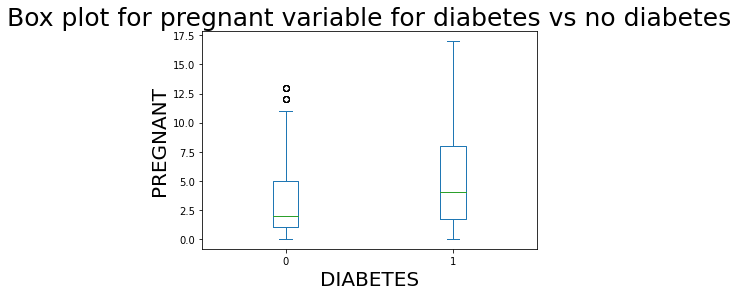

None
Rango intercuartílico: 5.0
Lower and upper outlier limits: -6.5 ,  13.5
We have a total of 4 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
88,15,136,70,32,110,37.1,0.153,43,1
159,17,163,72,41,114,40.9,0.817,47,1
298,14,100,78,25,184,36.6,0.412,46,1
455,14,175,62,30,0,33.6,0.212,38,1


In [47]:
# Boxplot
pregnant_boxplt = boxplt('PREGNANT', 'Box plot for pregnant variable for diabetes vs no diabetes')
print(pregnant_boxplt)
# Outliers
pregnant_outl = outliers(diabetes.PREGNANT)
pregnant_outl

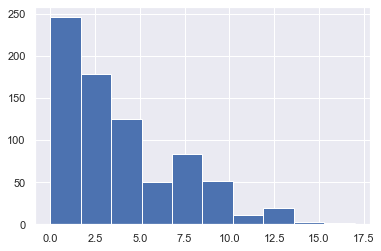

In [71]:
sns.set()
diabetes.PREGNANT.hist()
plt.show()

**Conclusión de los outliers para PREGNANT**


La mayoría de los casos se dan en 0, 1 y 2 embarazos, como podemos ver en el histograma. 0 embarazos es normal, y 17 embarazos no es muy probable, pero también se puede dar el caso.


Al tratarse de valores que se pueden dar en casos reales, hemos decidido no eliminar o sustituir los outliers por otros valores.

## GLUCOSE

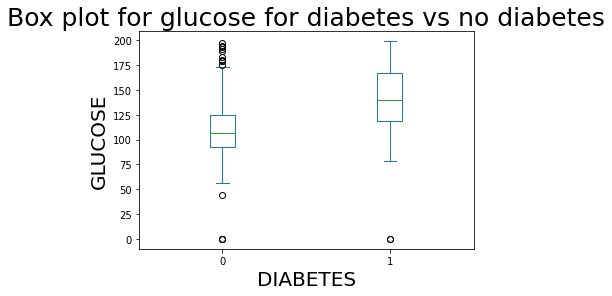

None
Rango intercuartílico: 41.25
Lower and upper outlier limits: 37.125 ,  202.125
We have a total of 5 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [49]:
# Boxplot
glucose_boxplt = boxplt('GLUCOSE', 'Box plot for glucose for diabetes vs no diabetes')
print(glucose_boxplt)
# Outliers
glucose_outl = outliers(diabetes.GLUCOSE)
glucose_outl

El bajo nivel de azúcar en la sangre grave es una emergencia médica. Puede ocasionar crisis epilépticas y daño cerebral.
Al nivel de azúcar en la sangre por debajo de los 70 mg/dL se lo considera bajo.

Por lo que en esta variable hemos decidido eliminar los outliers, ya que un valor de glucosa igual a 0 es imposible.

## BLOODPRESS

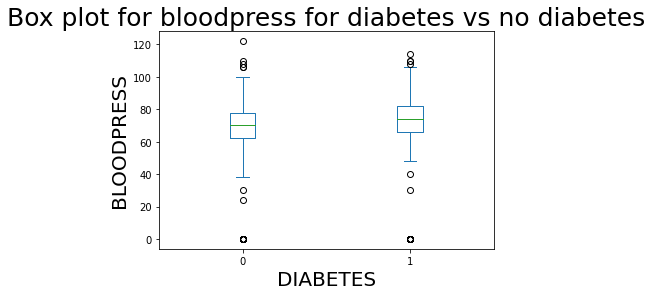

None
Rango intercuartílico: 18.0
Lower and upper outlier limits: 35.0 ,  107.0
We have a total of 45 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
18,1,103,30,38,83,43.3,0.183,33,0
43,9,171,110,24,240,45.4,0.721,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
84,5,137,108,0,0,48.8,0.227,37,1
106,1,96,122,0,0,22.4,0.207,27,0


In [50]:
# Boxplot
bloodpress_boxplt = boxplt('BLOODPRESS', 'Box plot for bloodpress for diabetes vs no diabetes')
print(bloodpress_boxplt)
# Outliers
bloodpress_outl = outliers(diabetes.BLOODPRESS)
bloodpress_outl

En la variable 'BLOODPRESS' el mínimo es 0, esto significa que la presión arterial demasiado baja, lo que puede provocar la disminución de los niveles de oxígeno del cuerpo y provocar daño al corazón y al cerebro. 

Por otra parte, el máximo de presión arterial es 122, se considera una presión arterial alta en torno a 80 en adelante.

Por ambas razones, hemos decidido eliminar los outliers en esta variable.

## BODYMASSINDEX

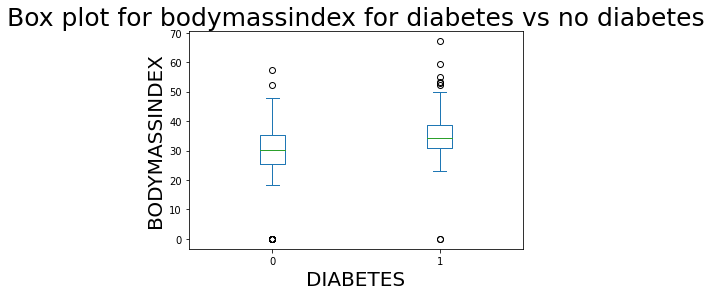

None
Rango intercuartílico: 9.3
Lower and upper outlier limits: 13.35 ,  50.550000000000004
We have a total of 19 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
120,0,162,76,56,100,53.2,0.759,25,1
125,1,88,30,42,99,55.0,0.496,26,1
145,0,102,75,23,0,0.0,0.572,21,0
177,0,129,110,46,130,67.1,0.319,26,1
193,11,135,0,0,0,52.3,0.578,40,1
247,0,165,90,33,680,52.3,0.427,23,0


In [51]:
# Boxplot
bodymassindex_boxplt = boxplt('BODYMASSINDEX', 'Box plot for bodymassindex for diabetes vs no diabetes')
print(bodymassindex_boxplt)
# Outliers
bodymassindex_outl = outliers(diabetes.BODYMASSINDEX)
bodymassindex_outl

La variable 'BODYMASSINDEX' indica el índice de masa corporal, que se mide teniendo en cuenta el peso y la altura de cada persona. 

Hay 11 casos en los que el BODYMASSINDEX es igual a 0, esto significaría que la persona carecería de masa corporal, lo cual es imposible. 

Por ambas razones, hemos eliminado los outliers.

## INSULIN

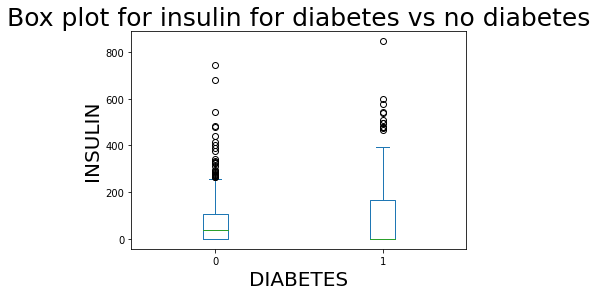

None
Rango intercuartílico: 127.25
Lower and upper outlier limits: -190.875 ,  318.125
We have a total of 34 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
54,7,150,66,42,342,34.7,0.718,42,0
111,8,155,62,26,495,34.0,0.543,46,1
139,5,105,72,29,325,36.9,0.159,28,0
153,1,153,82,42,485,40.6,0.687,23,0
186,8,181,68,36,495,30.1,0.615,60,1
220,0,177,60,29,478,34.6,1.072,21,1
228,4,197,70,39,744,36.7,2.329,31,0
231,6,134,80,37,370,46.2,0.238,46,1


In [52]:
# Boxplot
insulin_boxplt = boxplt('INSULIN', 'Box plot for insulin for diabetes vs no diabetes')
print(insulin_boxplt)
# Outliers
insulin_outl = outliers(diabetes.INSULIN)
insulin_outl

La variable 'INSULINA', lo normal es que sea de 5-26 U/ml. Por lo que en la gráfica de insulina es normal que haya tantos "outliers" alrededor del 0. 

## SKINTHICKNESS

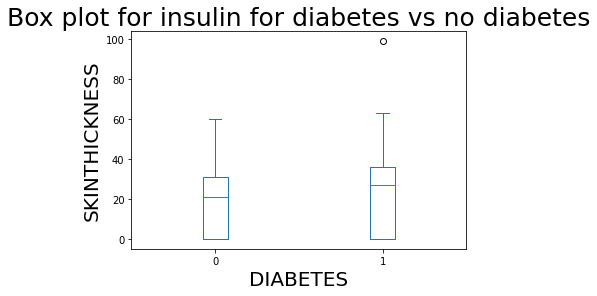

None
Rango intercuartílico: 32.0
Lower and upper outlier limits: -48.0 ,  80.0
We have a total of 1 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
579,2,197,70,99,0,34.7,0.575,62,1


In [53]:
# Boxplot
skinthickness_boxplt = boxplt('SKINTHICKNESS', 'Box plot for insulin for diabetes vs no diabetes')
print(skinthickness_boxplt)
# Outliers
skinthickness_outl = outliers(diabetes.SKINTHICKNESS)
skinthickness_outl

## PEDIGREEFUNC

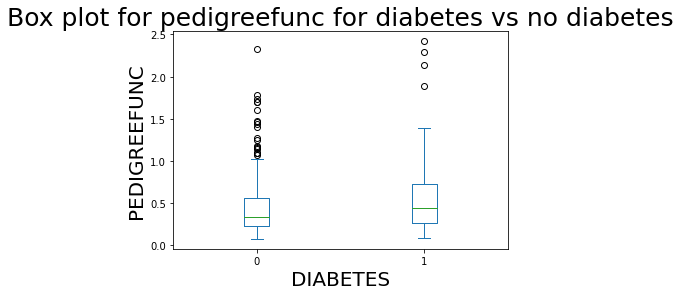

None
Rango intercuartílico: 0.38249999999999995
Lower and upper outlier limits: -0.32999999999999996 ,  1.2
We have a total of 29 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
4,0,137,40,35,168,43.1,2.288,33,1
12,10,139,80,0,0,27.1,1.441,57,0
39,4,111,72,47,207,37.1,1.390,56,1
45,0,180,66,39,0,42.0,1.893,25,1
58,0,146,82,0,0,40.5,1.781,44,0
100,1,163,72,0,0,39.0,1.222,33,1
147,2,106,64,35,119,30.5,1.400,34,0
187,1,128,98,41,58,32.0,1.321,33,1
218,5,85,74,22,0,29.0,1.224,32,1
228,4,197,70,39,744,36.7,2.329,31,0


In [54]:
# Boxplot
pedigreefunc_boxplt = boxplt('PEDIGREEFUNC', 'Box plot for pedigreefunc for diabetes vs no diabetes')
print(pedigreefunc_boxplt)
# Outliers
pedigreefunc_outl = outliers(diabetes.PEDIGREEFUNC)
pedigreefunc_outl

## AGE

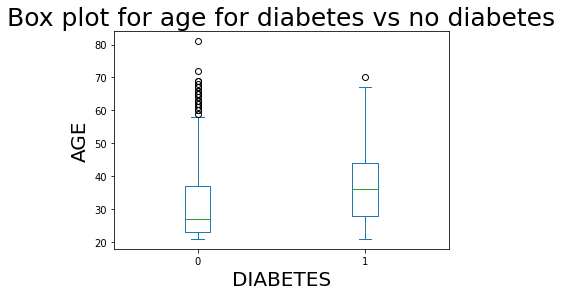

None
Rango intercuartílico: 17.0
Lower and upper outlier limits: -1.5 ,  66.5
We have a total of 9 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
123,5,132,80,0,0,26.8,0.186,69,0
363,4,146,78,0,0,38.5,0.520,67,1
453,2,119,0,0,0,19.6,0.832,72,0
459,9,134,74,33,60,25.9,0.460,81,0
489,8,194,80,0,0,26.1,0.551,67,0
537,0,57,60,0,0,21.7,0.735,67,0
666,4,145,82,18,0,32.5,0.235,70,1
674,8,91,82,0,0,35.6,0.587,68,0
684,5,136,82,0,0,0.0,0.640,69,0


In [56]:
# Boxplot
age_boxplt = boxplt('AGE', 'Box plot for age for diabetes vs no diabetes')
print(age_boxplt)
# Outliers
age_outl = outliers(diabetes.AGE)
age_outl

In [24]:
## FALTA COMENTAR PORQUE QUITAMOS O NO LOS OUTLIERS DE ALGUNAS VARIABLES

Pregnant

### STEP 4: ENCODE CATEGORICAL VARIABLES

In [26]:
#There are no categorical input variables, but 'DIABETES' would be a categorical value.
### Convert output variable to factor, in this case 'DIABETES' is a categorical variable.
diabetes.DIABETES = diabetes.DIABETES.astype('category') 
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PREGNANT       768 non-null    int64   
 1   GLUCOSE        768 non-null    int64   
 2   BLOODPRESS     768 non-null    int64   
 3   SKINTHICKNESS  768 non-null    int64   
 4   INSULIN        768 non-null    int64   
 5   BODYMASSINDEX  768 non-null    float64 
 6   PEDIGREEFUNC   768 non-null    float64 
 7   AGE            768 non-null    int64   
 8   DIABETES       768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


### STEP 5: EXPLORATORY ANALYSIS
Correlation plot of numeric variables

In [19]:
diabetes.BODYMASSINDEX.min()
dia = len(diabetes.loc[diabetes.BODYMASSINDEX == 0])
dia

11

In [24]:
diabetes.PEDIGREEFUNC.max()

2.42

En cuanto a la variable 'PREGNANT', el máximo es de 17 embarazos, algo que es posible que suceda, por lo tanto hemos decidido no eliminar los outliers de esta variable.


La variable 'GLUCOSE' es la variable respuesta o output.


En la variable 'BLOODPRESS' el mínimo es 0, esto significa que la presión arterial demasiado baja puede disminuir los niveles de oxígeno del cuerpo y provocar daño al corazón y al cerebro. Por otra parte, el máximo de presión arterial es 122, se considera una presión arterial alta en torno a 80 en adelante.


Después tenemos la variable 'SKINTHICKNESS', que tiene un outlier con el valor 99. y QUE HACEMOS CON ESTE ÚNICO VALOR 99
El mínimo es 0, hay 227 casos en los que el paciente tiene 0 mm de grosor de pliegue cutáneo del triceps. QUE HACEMOS?????????????????



La variable 'INSULINA', lo normal es que sea de 5-26 U/ml. Por lo que en la gráfica de insulina es normal que haya tantos "outliers" alrededor del 0.



La variable 'BODYMASSINDEX' indica el índice de masa corporal, que se mide teniendo en cuenta el peso y la altura de cada persona. Hay 11 casos en los que el BODYMASSINDEX es igual a 0, esto significaría que la persona carecería de masa corporal, lo cual es imposible. Aquí habría que tratar estos outliers, tenemos dos opciones, eliminarlos o sustituirlos por la media. Al tener un total de 788 observaciones, convendría tratarlos sussituyendo el valor de 0 por la media de la variable, en este caso es 32.


Por otro lado tenemos la variable 'PEDIGREEFUNC' que representa una síntesis de la historia de la diabetes mellitus en familiares y la genética de estos parientes con el sujeto. Esta variable, cuanto mas alto sea su valor, más familiares tendrá con dibabetes. En este caso podemos ver en el boxplot muchos outliers por encima de 1,25. El valor mínimo es 0.078, y el valor máximo es de 2.42. 


In [61]:
! pip install imblearn --quiet

In [62]:
# import library
from imblearn.over_sampling import SMOTE
smote = SMOTE()

 

x = diabetes.loc[:, diabetes.columns != 'DIABETES']
y = diabetes.DIABETES
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)
print('Original dataset shape', len(y))
print('Resample dataset shape', len(y_smote))
diabetes_new = x_smote
diabetes_new['DIABETES']=y_smote
diabetes_new
diabetes_new.DIABETES.value_counts()

Original dataset shape 768
Resample dataset shape 1000


1    500
0    500
Name: DIABETES, dtype: int64

In [66]:
def outliers2 (datos):
    df_iqr = stats.iqr(datos)
    print(f"Rango intercuartílico: {df_iqr}")
    # Para localizar el primer y tercer cuartil.
    df_q1, df_q3 = np.quantile(datos, [0.25, 0.75])
 
    # Limites de los valores atípicos
    cut_low = df_q1 - 1.5 * df_iqr
    cut_high = df_q3 + 1.5 * df_iqr
 
    print("Lower and upper outlier limits:", cut_low, ", ", cut_high)
 
    # Obtenemos de nuestro dataset todos los valores atípicos segun los limites calculados
    df_outliers = diabetes_new.loc[(datos < cut_low) | (datos > cut_high)]

    # Representación mediante boxpots (sección gráficos)

    print('We have a total of', len(df_outliers), 'outliers')

    return df_outliers

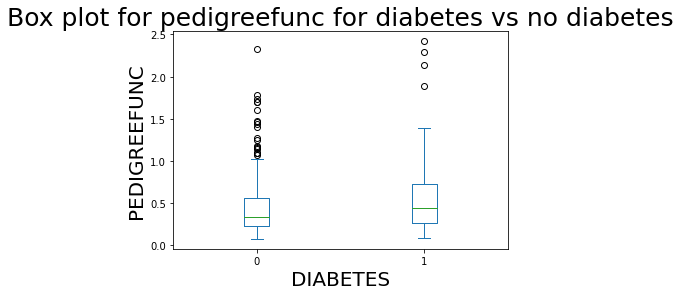

None
Rango intercuartílico: 0.394
Lower and upper outlier limits: -0.33299999999999996 ,  1.2429999999999999
We have a total of 29 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
4,0,137,40,35,168,43.100000,2.288000,33,1
12,10,139,80,0,0,27.100000,1.441000,57,0
39,4,111,72,47,207,37.100000,1.390000,56,1
45,0,180,66,39,0,42.000000,1.893000,25,1
58,0,146,82,0,0,40.500000,1.781000,44,0
147,2,106,64,35,119,30.500000,1.400000,34,0
187,1,128,98,41,58,32.000000,1.321000,33,1
228,4,197,70,39,744,36.700000,2.329000,31,0
243,6,119,50,22,176,27.100000,1.318000,33,1
259,11,155,76,28,150,33.300000,1.353000,51,1


In [67]:
# Boxplot
pedigreefunc_boxplt = boxplt('PEDIGREEFUNC', 'Box plot for pedigreefunc for diabetes vs no diabetes')
print(pedigreefunc_boxplt)
# Outliers
pedigreefunc_outl = outliers2(diabetes_new.PEDIGREEFUNC)
pedigreefunc_outl

## Decision Tree

In [82]:
# Define input and output matrices
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
OUTPUT = 'DIABETES'
X = diabetes[INPUTS]
y = diabetes[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

In [83]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
INPUTS_DT = INPUTS

# valor que vamos a utilizar para la validacion cruzada. np.arange(0,0.05,0.005) los valores que ponemos ahi dependerán
param = {'DT__min_impurity_decrease': np.arange(0, 0.05, 0.005)} # Minimum entropy to decrease in each split
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting - minimo numero de muestras en un split
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node - minimo numero de muestras en un nodo terminal
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
# Elejimos el arbol con GridSearchCV
# en GridSearchCV mete los hiperparámetros - Cuantos mas variables 
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use 
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='accuracy')

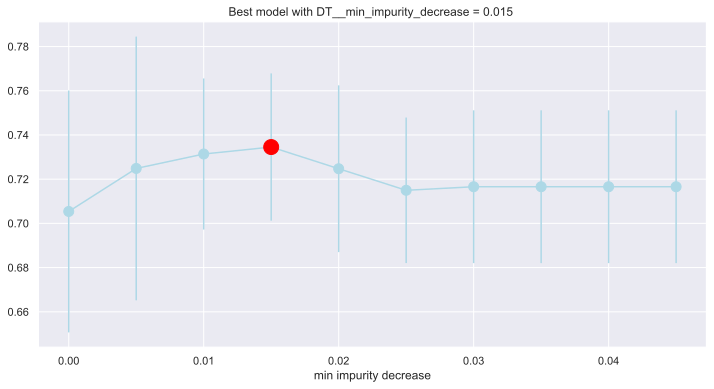

In [84]:
MT.plotModelGridError(tree_fit)

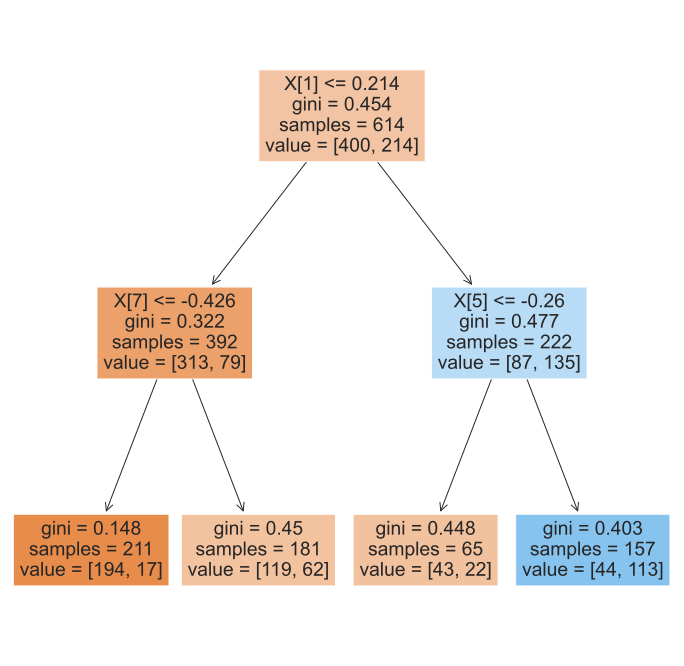

In [85]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

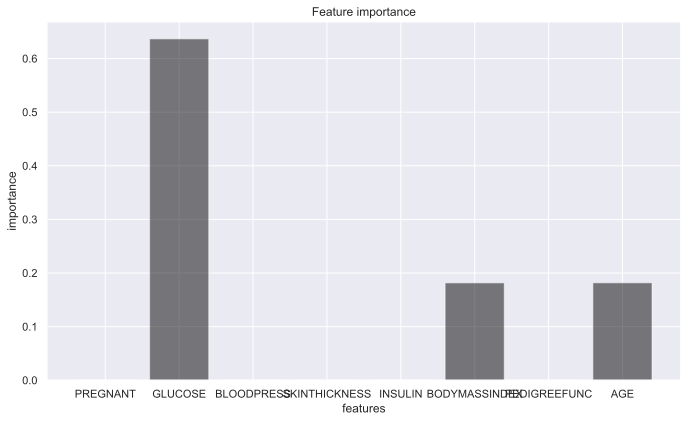

In [86]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.show()